In [42]:
import mne
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm
import glob
from matplotlib import pyplot as plt

In [43]:
_dfs_list = []
for csv_filename in tqdm(glob.glob('/Users/dmitrykorzhov/Desktop/Root/projects/bci_stuff/alcoholic_data_eeg/SMNI_CMI_TRAIN/*.csv')):
    _dfs_list.append(pd.read_csv(csv_filename))
df = pd.concat(_dfs_list)
del(_dfs_list)
df = df.drop(['Unnamed: 0'], axis=1)


100%|██████████| 468/468 [00:03<00:00, 145.80it/s]


In [44]:
channel_list = list(set(df['sensor position']))
channel_list.sort()


channel_list = list(set(df['sensor position']))
channel_list.sort()

channel_mapping = {
    'AFZ':'AFz', 
    'CPZ':'CPz', 
    'CZ':'Cz', 
    'FCZ':'FCz', 
    'FP1':'Fp1',
    'FP2':'Fp2', 
    'FPZ':'Fpz', 
    'FZ':'Fz', 
    'OZ':'Oz', 
    'POZ':'POz', 
    'PZ':'Pz',
}

channel_mapping_full = dict()

for ch in channel_list:
    if ch in channel_mapping:
        channel_mapping_full[ch] = channel_mapping[ch]
    else:
        channel_mapping_full[ch] = ch

channel_list_fixed = [channel_mapping_full[ch] for ch in channel_list]
        
df['sensor position'] = df['sensor position'].map(channel_mapping_full)

In [45]:
transposed_df_list = []

for group_df in tqdm(df.groupby(['name', 'trial number', 'matching condition', 'sensor position', 'subject identifier'])):
    _df = pd.DataFrame(group_df[1]['sensor value']).T
    _df.columns = [f'sample_{idx}' for idx in range(256)]
    _df['name'] = group_df[0][0]
    _df['trial number'] = group_df[0][1]
    _df['matching condition'] = group_df[0][2]
    _df['sensor position'] = group_df[0][3]
    _df['subject identifier'] = group_df[0][4]
    
    transposed_df_list.append(_df)
    
df = pd.concat(transposed_df_list)
df = df[[*df.columns[-5:],*df.columns[0:-5]]]
df = df.reset_index(drop=True)
df.head(3)

100%|██████████| 29952/29952 [00:14<00:00, 2108.35it/s]


,name,trial number,matching condition,sensor position,subject identifier,sample_0,sample_1,sample_2,sample_3,sample_4,...,sample_246,sample_247,sample_248,sample_249,sample_250,sample_251,sample_252,sample_253,sample_254,sample_255
0,co2a0000364,0,S1 obj,AF1,a,-2.146,-2.146,-1.658,-0.682,2.248,...,-1.658,0.295,2.736,4.201,3.713,1.272,-0.682,-0.193,3.225,7.619
1,co2a0000364,0,S1 obj,AF2,a,1.129,0.641,-0.336,-0.824,0.641,...,4.059,-0.336,-2.777,-0.824,3.571,5.035,4.059,2.106,1.617,4.059
2,co2a0000364,0,S1 obj,AF7,a,-16.856,-7.090,7.558,19.277,23.183,...,17.324,9.511,1.699,-2.207,-2.207,1.211,5.117,8.046,10.000,11.464


In [46]:
df_people = df.groupby('subject identifier').apply(lambda x: x['name'].unique()).reset_index()
df_people.columns = ['subject identifier', 'names']
df_people

,subject identifier,names
0,a,"[co2a0000364, co2a0000365, co2a0000368, co2a00..."
1,c,"[co2c0000337, co2c0000338, co2c0000339, co2c00..."


In [7]:
def get_record_df(df, name, trial_number, matching_condition, channel_list):
    df_record = df[df['name'].eq(name) & df['trial number'].eq(trial_number) & df['matching condition'].eq(matching_condition)].set_index(['sensor position']).loc[channel_list]
    return df_record


def get_signal_array(df, name, trial_number, matching_condition, channel_list):
    df_record = get_record_df(df, name, trial_number, matching_condition, channel_list)
    return df_record.to_numpy()[:, 4:]

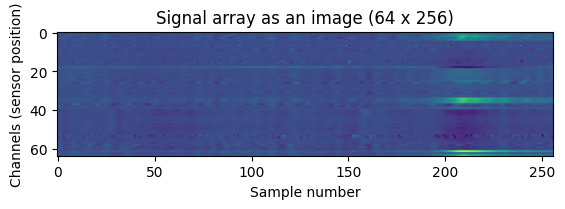

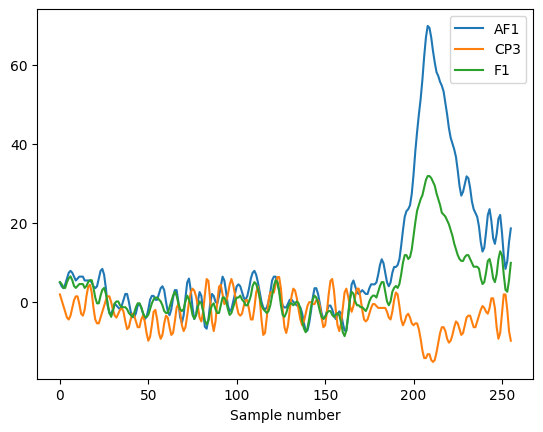

In [48]:
signal_array = get_signal_array(df, 'co2a0000364', 10, 'S1 obj', channel_list_fixed)

plt.title('Signal array as an image (64 x 256)')
plt.ylabel('Channels (sensor position)');
plt.xlabel('Sample number');
plt.imshow(signal_array.astype(int));
plt.show()

channels_to_display = ['AF1', 'CP3', 'F1']
for channel in channels_to_display:
    plt.xlabel('Sample number');
    plt.plot(signal_array[channel_list.index(channel)]);
plt.legend(channels_to_display);

In [32]:
signal_array.shape

(64, 256)

## MNE Load

In [9]:
info = mne.create_info(ch_names=channel_list_fixed, sfreq=256, ch_types=['eeg']*64)
raw = mne.io.RawArray(signal_array, info)

standard_1020_montage = mne.channels.make_standard_montage('standard_1020');
raw.drop_channels(['X', 'Y', 'nd'])
raw.set_montage(standard_1020_montage)

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,61 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)


/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


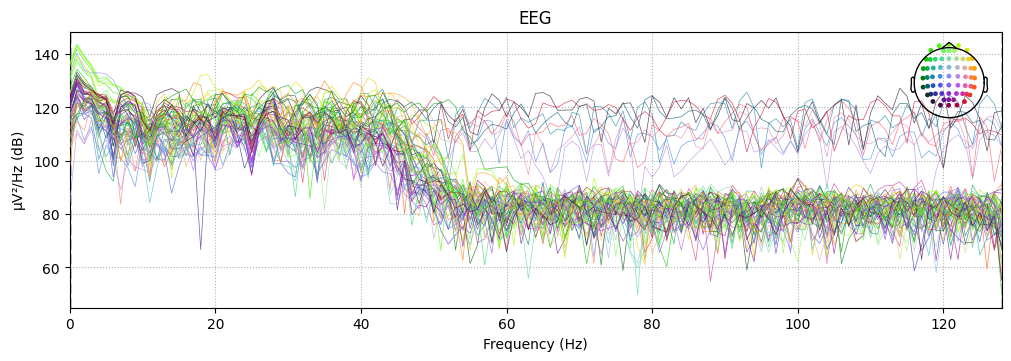

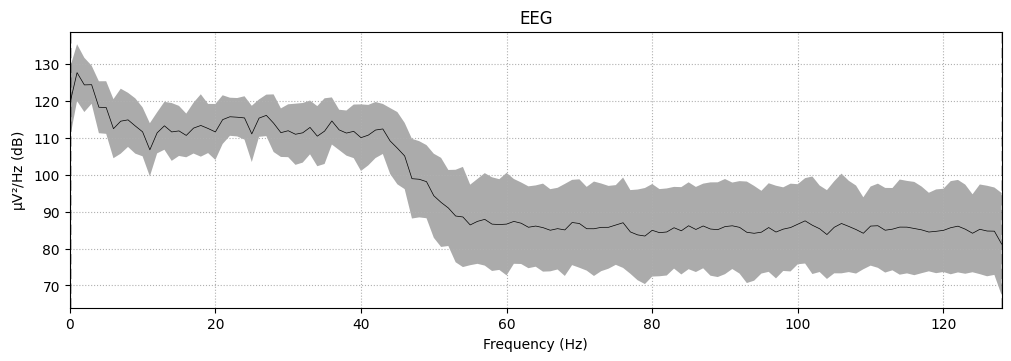

In [10]:
raw.plot_psd();
raw.plot_psd(average=True);

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)


/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_17361/2099550416.py:1: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw_filtered = raw.copy().filter(8,30, verbose=False);
/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


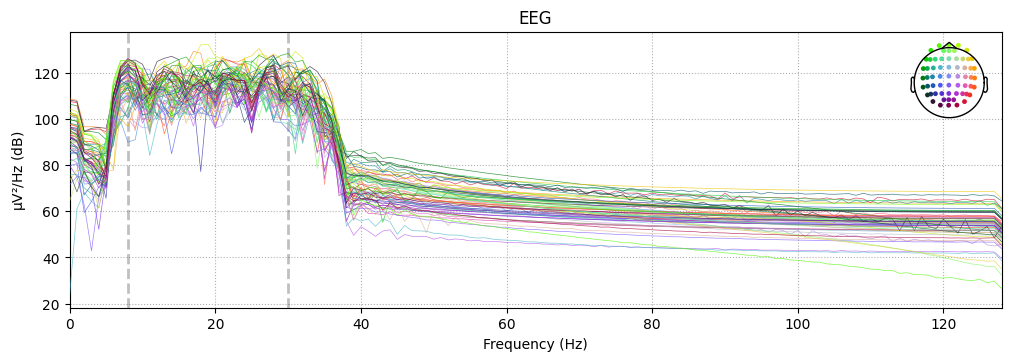

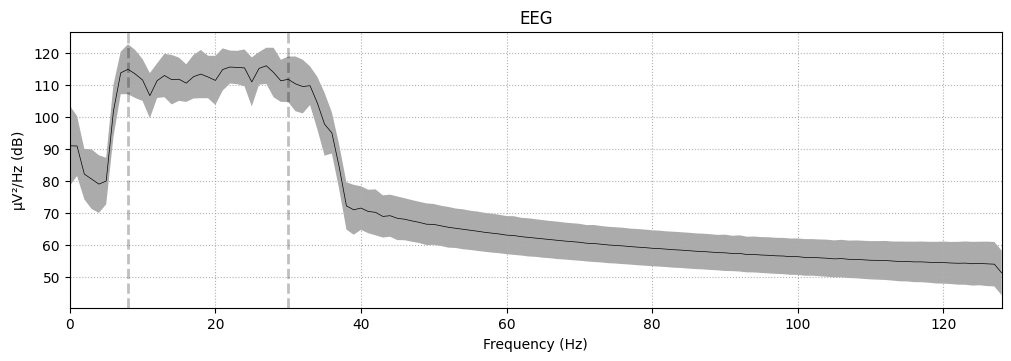

In [11]:
raw_filtered = raw.copy().filter(8,30, verbose=False);
raw_filtered.plot_psd();
raw_filtered.plot_psd(average=True);

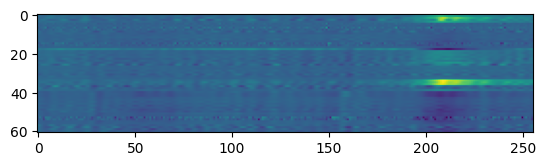

/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_17361/3450553692.py:3: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  plt.imshow(raw.copy().filter(1,10, verbose=False).get_data());


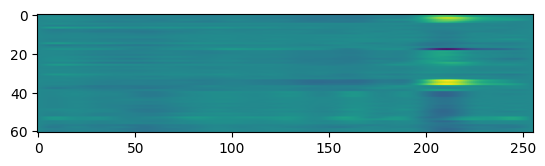

/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_17361/3450553692.py:6: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  plt.plot(raw.copy().filter(8,30, verbose=False).get_data()[40])


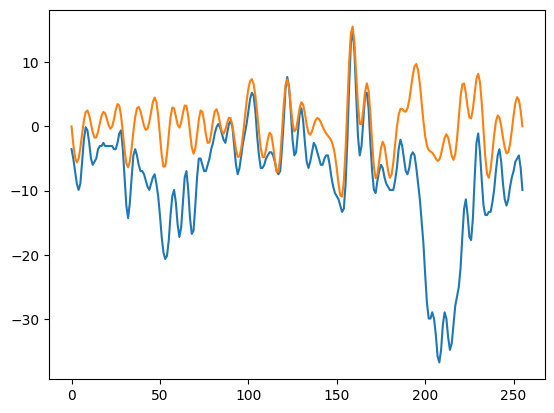

In [12]:
plt.imshow(raw.get_data())
plt.show()
plt.imshow(raw.copy().filter(1,10, verbose=False).get_data());
plt.show()
plt.plot(raw.copy().get_data()[40])
plt.plot(raw.copy().filter(8,30, verbose=False).get_data()[40])

/var/folders/km/11btm21d4530p5z43fq0m17w0000gn/T/ipykernel_17361/858203707.py:2: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  ica.fit(raw.copy().filter(1,None, verbose=False), verbose=False)
/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


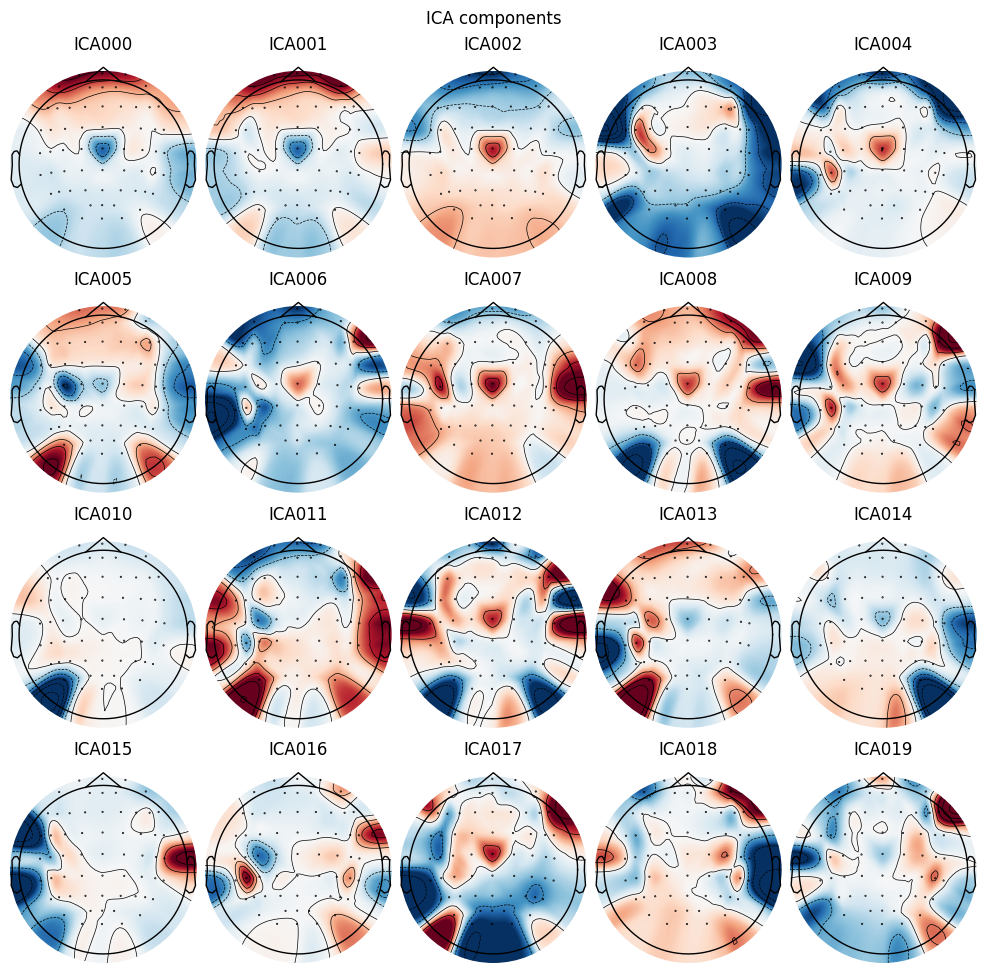

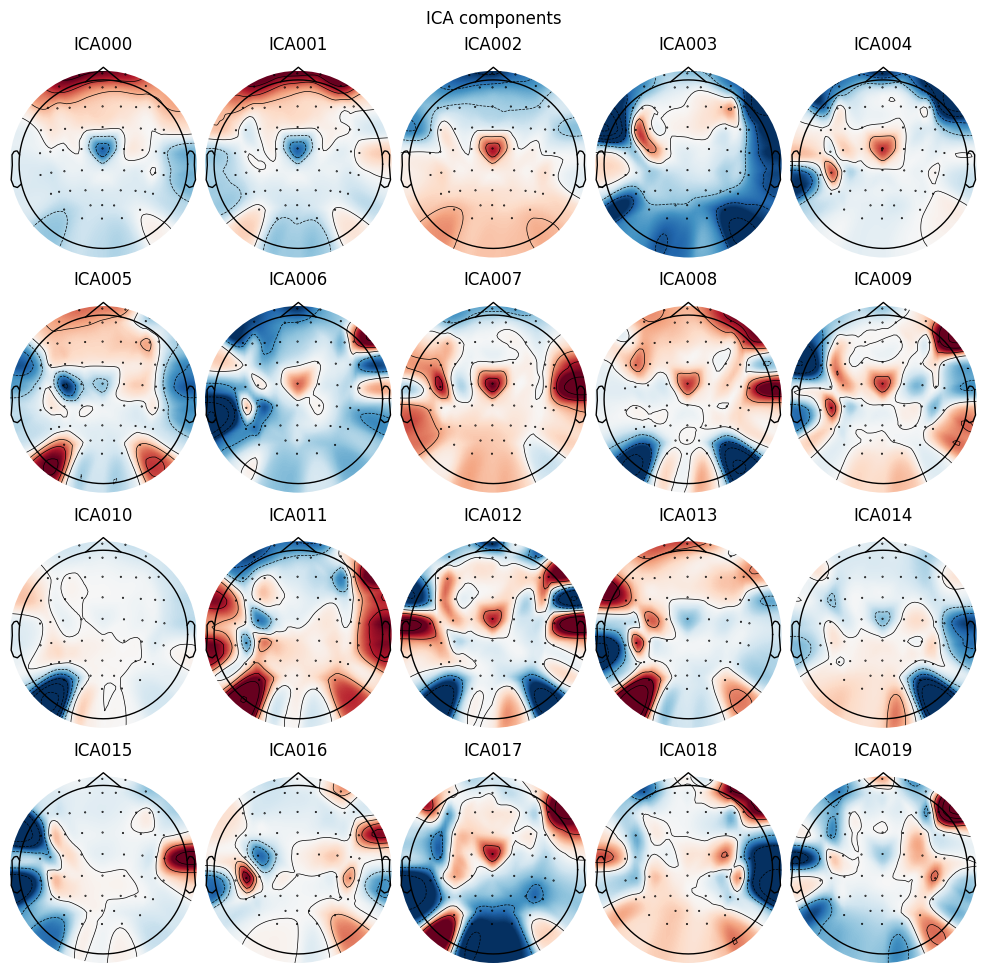

In [13]:
ica = mne.preprocessing.ICA(random_state=42, n_components=20)
ica.fit(raw.copy().filter(1,None, verbose=False), verbose=False)
ica.plot_components()

In [14]:
def plot_eeg_topomap(signal_array, save_path_animation=None, show_names=False, start_time=0.05, end_time=1, step_size=0.1):
    montage = mne.channels.make_standard_montage('standard_1020')
    ch_to_remove = []
    
    for ch in channel_list_fixed:
        if ch not in list(set(montage.ch_names).intersection(channel_list_fixed)):
            ch_to_remove.append(channel_list_fixed.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)
    
    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(channel_list_fixed)), sfreq=256, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)

    evoked.set_montage(montage)

    evoked.plot_topomap(np.arange(start_time, end_time, step_size), ch_type='eeg', time_unit='s', ncols=5, nrows=2, show_names=show_names);

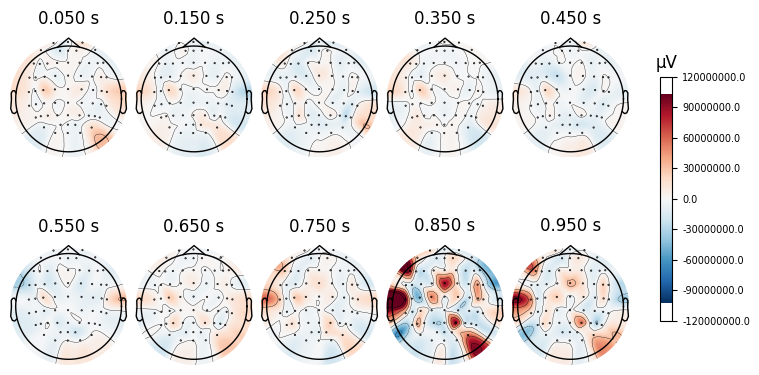

In [15]:
plot_eeg_topomap(signal_array, show_names=False)

In [16]:
def plot_eeg_topomap_animation(signal_array, save_path_animation, start_time=0.00, end_time=1, step_size=0.01, frame_rate=10):
    montage = mne.channels.make_standard_montage('standard_1020')
    
    ch_to_remove = []
    for ch in channel_list_fixed:
        if ch not in list(set(montage.ch_names).intersection(channel_list_fixed)):
            ch_to_remove.append(channel_list_fixed.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)

    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(channel_list_fixed)), sfreq=256, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)

    evoked.set_montage(montage)
    
    if save_path_animation:
        fig, anim = evoked.animate_topomap(times=np.arange(start_time, end_time, step_size), frame_rate=frame_rate, butterfly=True, blit=False, );
        anim.save(save_path_animation);
        print('saved to', save_path_animation)

In [53]:
signal_array_control = get_signal_array(df, 'co2c0000338', 10, 'S1 obj', channel_list_fixed)
signal_array_alcoholic = get_signal_array(df, 'co2a0000364', 10, 'S1 obj', channel_list_fixed)

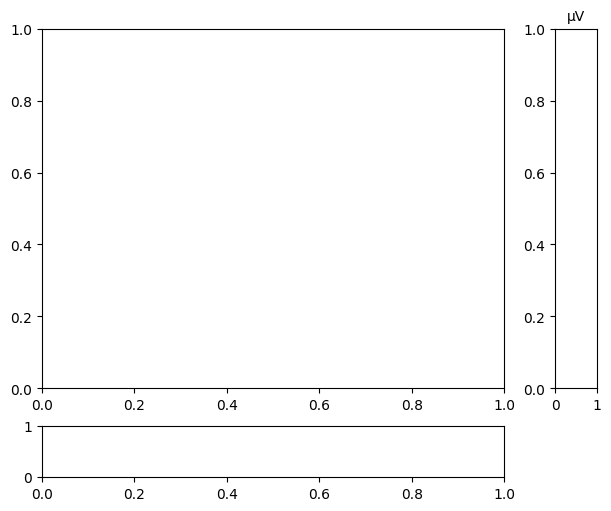

Initializing animation...
saved to ./gif_alcoholic.gif


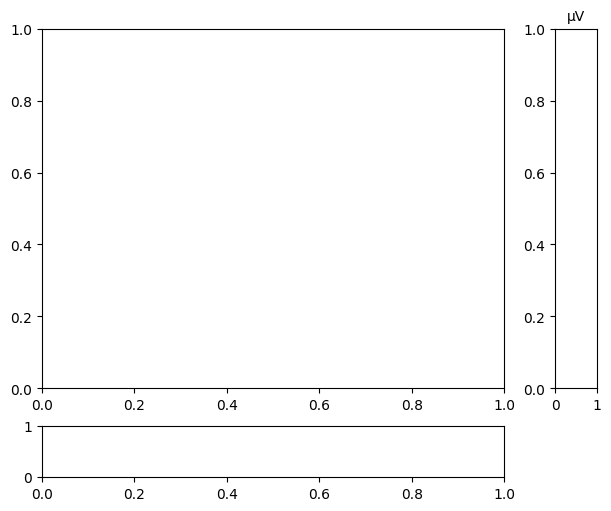

Initializing animation...
saved to ./gif_control.gif


In [54]:
gif_al = plot_eeg_topomap_animation(signal_array_alcoholic, './gif_alcoholic.gif')
gif_control = plot_eeg_topomap_animation(signal_array_control, './gif_control.gif')

In [19]:
def plot_eeg_joint_topomap(signal_array, save_path_animation=None, show_names=False, start_time=0.05, end_time=1, step_size=0.1):
    montage = mne.channels.make_standard_montage('standard_1020')
    
    ch_to_remove = []
    for ch in channel_list_fixed:
        if ch not in list(set(montage.ch_names).intersection(channel_list_fixed)):
            ch_to_remove.append(channel_list_fixed.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)

    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(channel_list_fixed)), sfreq=256, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)

    evoked.set_montage(montage)

    evoked.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


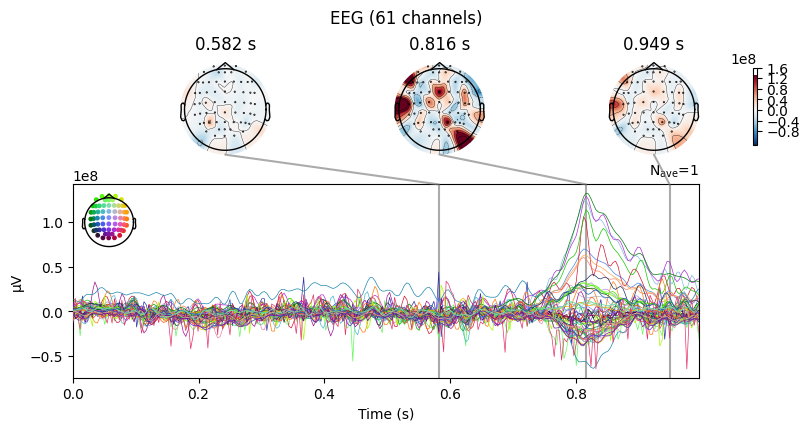

In [20]:
plot_eeg_joint_topomap(signal_array)